# Exploring Agglomerative Clustering
Author: Tristan Miller

I originally intended to make a validation measure for agglomerative clustering, but a lot of this is just exploring so far.

### Initialization
Here I'm just copying code from a bunch of other notebooks

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
import scipy
from sklearn.decomposition import PCA
import lda #use pip install lda 
import time
from sklearn.cluster import AgglomerativeClustering
import sys

In [15]:
#Load data, document-term matrix
data = pd.read_pickle("processed_10k_articles.pkl")
unweighted_words = np.reshape(np.load("document_term_matrix.npy"),(1))[0]
term_list = pd.read_pickle("term_list.pkl")[0].tolist()

In [20]:
#Apply LDA with 30 topics
start_time = time.time()
model = lda.LDA(n_topics=30, n_iter=1500, random_state=1)
model.fit(unweighted_words.toarray())
processing_time = (time.time() - start_time)/60
print("Time to execute: %.2f minutes" % processing_time )

Time to execute: 1.90 minutes


In [28]:
topic_word = model.topic_word_
doc_topic = model.doc_topic_

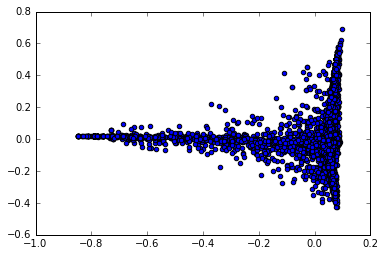

In [30]:
#apply PCA
pca=PCA(n_components=2)
doc_topic_PCA=pca.fit_transform(doc_topic)
%matplotlib inline
plt.scatter(doc_topic_PCA[:,0], doc_topic_PCA[:,1])

In [43]:
#Ward Agglomerative clustering
start_time = time.time()
clustering = AgglomerativeClustering(linkage="ward", n_clusters=10)
c_labels = clustering.fit_predict(doc_topic)
processing_time = (time.time() - start_time)/60
print("Time to execute: %.2f minutes" % processing_time )

Time to execute: 2.85 minutes


## Understanding the clustering

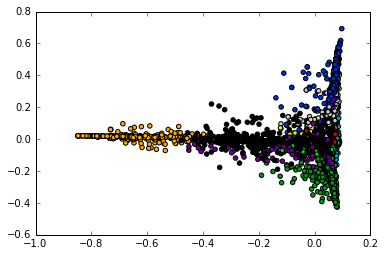

In [78]:
plt.scatter(doc_topic_PCA[:, 0], doc_topic_PCA[:, 1], c=c_labels,
                        cmap=plt.cm.spectral)

In [81]:
children = clustering.children_
print("Labels of first 20 articles:",c_labels[0:20])
print("First 20 nodes:",children[0:20])

Labels of first 20 articles: [0 0 0 3 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
First 20 nodes: [[    3  3065]
 [   64  5117]
 [  552  5217]
 [  720  9818]
 [  887  3416]
 [  903  2170]
 [  909  2535]
 [ 1121  1511]
 [ 1211  5713]
 [ 1407  7833]
 [ 1429  1811]
 [ 1482  2268]
 [ 2172 10007]
 [ 1576  1578]
 [ 1812 10010]
 [ 1823 10014]
 [ 1813  1955]
 [ 1833 10015]
 [ 1883 10017]
 [ 1872  3257]]


What's this all mean?

Apparently, children[x] is the xth node in the tree.  There are 9999 nodes, which is 1 less than the number of documents in the tree.  Documents are not themselves nodes, but rather the leaves of the tree.

children[children[x][0]-10000] is the left child of the xth node, and children[children[x][1]-10000] is the right child.  If children[x][y] is less than 10000 (the number of documents), then the child referred to is not another node, but document number children[x][y]

After making a tree, the algorithm somehow selects N clusters from it.  Cluster number 0 is obviously the biggest cluster

### Translating the tree
The above format is a really counterintuitive way to think about trees, so I'm translating it to a better format.

In [380]:
if 'cluster_tree' in sys.modules:
    del sys.modules['cluster_tree'] #this just makes sure the import updates every time
from cluster_tree import *

In [381]:
#I wrote a TreeNode class, and translated the output of the clustering to it
root = tree_to_nodes(children,10000)

In [382]:
#Now I can classify each leaf
classified_tree = classify_tree(root,c_labels)
#And produce a reduced tree that only shows the clusters relative to each other
label_tree = get_label_tree(classified_tree)

In [383]:
str(label_tree)

'(7,(2,(4,((6,9),(5,((1,0),(8,3)))))));'

### Basic visualization

In [384]:
#pip install ete3
#this is from here: http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html
from ete3 import Tree, TreeStyle
t = Tree(str(label_tree))
ts = TreeStyle()
ts.show_leaf_name = True
ts.scale =  12
t.show(tree_style=ts)
#output is in a different window.

# Allowing more than 2 children per node
The problem with the agglomerative clustering algorithms is that they produce *binary* trees, where each node has two children.  Intuitively, a topic may sometimes have more than two subtopics.

We need two things:
1. A way to collapse a non-leaf node with a non-leaf child.  That is, go from (A,(B,C)) to (A,B,C).
2. An algorithm that finds all times when this is appropriate.

Intuitively, (A,(B,C)) should be converted to (A,B,C) when A,B, and C are about equidistant from each other.  Although it's possible that A,B, and C are collinear.  So the condition would be dist(B,C) ~> dist(A,B) OR dist(B,C) ~> dist(A,C).

More generally, we might have a branch that looks like (A,B,(C,D,E)).  grandchild_separation is the smallest distance between any pairs of C,D,E.  child_separation is the smallest distance between any pair, where one of the pair is taken from (A,B), and the other of the pair is taken from (C,D,E).  The branch is collapsed to (A,B,C,D,E) if grandchild_separation ~> child_separation.

Now all we need to do is define the "dist" and "~" operations.  As a first attempt, I will define "dist" as the distance between means of the clusters.  "~" will be defined as having a tolerance of 10%.

In [385]:
#Get all cluster means.
(cm,docs_in_cluster) = get_means(c_labels,doc_topic)

In [386]:
#In the label tree we computed above, one of the branches is ((1,0),(8,3))
#does this mean that 1 and 0 are closer to each other than 3 and 8?
print('Distance between 0 and 1: ' + str(get_dist(cm,0,1)))
print('Distance between 3 and 8: ' + str(get_dist(cm,3,8)))
print('Distance between 0 and 3: ' + str(get_dist(cm,0,3)))
print('Distance between 0 and 8: ' + str(get_dist(cm,0,8)))
print('Distance between 1 and 3: ' + str(get_dist(cm,1,3)))
print('Distance between 1 and 8: ' + str(get_dist(cm,1,8)))

Distance between 0 and 1: 0.31213413364945886
Distance between 3 and 8: 0.5790946671630695
Distance between 0 and 3: 0.4456421436544012
Distance between 0 and 8: 0.4232201340936959
Distance between 1 and 3: 0.5440208841637848
Distance between 1 and 8: 0.5286102598987678


Under the algorithm described above, we would reduce the branch to ((1,0),3,8)

In [393]:
#now let's apply the algorithm described above, with zero tolerance
collapsed_tree = collapse_label_tree(label_tree,cm,docs_in_cluster,0)
str(collapsed_tree)

'(7,(2,(4,5,8,3,(1,0),6,9)));'

In [394]:
t = Tree(str(collapsed_tree))
t.show(tree_style=ts)

In [392]:
#Does 10% tolerance make a difference?
collapsed_tree = collapse_label_tree(label_tree,cm,docs_in_cluster,.1)
str(collapsed_tree)

'(7,(2,(4,5,(0,1,3,8),6,9)));'

Well that was nontrivial.  Maybe we'll just stick to tolerance=0 for now.

### Summary and conclusion
Ward Agglomerative Clustering places all documents in a giant binary tree.  It then creates N clusters by picking various branches of the tree.  This not only classifies each document into one of N clusters, it also creates a topic tree, with the N clusters as its leaves.

The problem with this topic tree is that it is a binary tree.  However, it is relatively to collapse this tree so that it is no longer restricted to being binary.  The end result is a topic tree, with both "internal node" topics, and "leaf" topics.  Each document is classified within one of the leaves.

Of course, we still need to select the number of leaves, and it's possible that the algorithm for collapsing can be improved.  For these, we need a validation measure.